## Dataset preparation

In [1]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class DIV2KDataset(Dataset):
    def __init__(self, root: str, modification=None):
        """
        root        : Ścieżka do katalogu z obrazami .png
        modification: Funkcja (img: torch.Tensor) -> mask
                      Zwraca maskę, którą chcemy wykorzystać w PartialConv.
                      Jeśli None, zwróci maskę = same jedynki.
        """
        self.root = root
        self.image_paths = [
            os.path.join(root, f) for f in os.listdir(root)
            if f.lower().endswith(".png")
        ]
        self.transform = transforms.ToTensor()
        self.modification = modification

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # 1) Wczytaj obraz z dysku
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # ewentualnie zmniejszamy/zmieniamy rozmiar
        img = cv2.resize(img, (256, 256))

        # 2) Normalizacja do float [0,1]
        img = img.astype(np.float32) / 255.0

        # 3) Konwersja na tensor (C,H,W)
        img = self.transform(img)  # shape = (3, 256, 256)

        # 4) Jeśli mamy funkcję do generowania maski – wywołujemy ją.
        if self.modification is not None:
            mask = self.modification(img)  # np. add_random_mask -> TYLKO maska
        else:
            # Domyślnie maska jedynek
            C, H, W = img.shape
            mask = torch.ones((C, H, W), dtype=img.dtype)

        # 5) Zwracamy oryginalny obraz i maskę (osobno!)
        return img, mask

In [2]:
def add_random_mask(
    img: torch.Tensor,
    mask_size: tuple[int, int] = (64, 64),
    num_patches: int = 1
) -> torch.Tensor:
    """
    Generate a random mask (with the same rectangular region set to zero
    for every channel), but DO NOT multiply it with 'img' here.
    Returns only the mask.
    """
    C, H, W = img.shape
    mask = torch.ones((C, H, W), dtype=img.dtype)

    for _ in range(num_patches):
        x = np.random.randint(0, W - mask_size[0])
        y = np.random.randint(0, H - mask_size[1])
        mask[:, y:y+mask_size[1], x:x+mask_size[0]] = 0

    return mask

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%env DIV2K_DATA_PATH=/content/drive/MyDrive/sigk/data/DIV2K

env: DIV2K_DATA_PATH=/content/drive/MyDrive/sigk/data/DIV2K


In [5]:
from torch.utils.data import DataLoader

dataset = DIV2KDataset(
    root=f"{os.getenv('DIV2K_DATA_PATH')}/DIV2K_train_HR",
    modification=lambda img: add_random_mask(img, mask_size=(64,64), num_patches=3),
)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

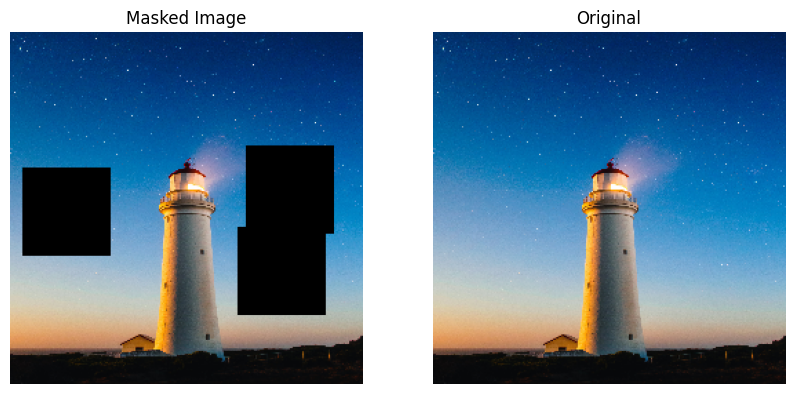

In [6]:
import matplotlib.pyplot as plt

# Pobierz pojedynczy batch
img_batch, mask_batch = next(iter(dataloader))

# Dla przykładu weźmy pierwszą próbkę w tym batchu
img = img_batch[0]   # shape = (C,H,W)
mask = mask_batch[0] # shape = (C,H,W)

# Nałóż maskę na obraz
masked_img = img * mask  # shape = (C,H,W)

# Rysowanie
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Po lewej - obrazek z nałożoną maską
axs[0].imshow(masked_img.permute(1, 2, 0).cpu().numpy())
axs[0].set_title("Masked Image")
axs[0].axis('off')

# Po prawej - oryginał
axs[1].imshow(img.permute(1, 2, 0).cpu().numpy())
axs[1].set_title("Original")
axs[1].axis('off')

plt.show()


In [7]:
img_batch, mask_batch = next(iter(dataloader))
print(mask_batch.size())

torch.Size([16, 3, 256, 256])


## Model definition

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

class PartialConv2d(nn.Conv2d):
    """
    Source: https://github.com/NVIDIA/partialconv/blob/master/models/partialconv2d.py
    """
    def __init__(self, *args, **kwargs):

        # whether the mask is multi-channel or not
        if 'multi_channel' in kwargs:
            self.multi_channel = kwargs['multi_channel']
            kwargs.pop('multi_channel')
        else:
            self.multi_channel = False

        if 'return_mask' in kwargs:
            self.return_mask = kwargs['return_mask']
            kwargs.pop('return_mask')
        else:
            self.return_mask = False

        super(PartialConv2d, self).__init__(*args, **kwargs)

        if self.multi_channel:
            self.weight_maskUpdater = torch.ones(self.out_channels, self.in_channels, self.kernel_size[0], self.kernel_size[1])
        else:
            self.weight_maskUpdater = torch.ones(1, 1, self.kernel_size[0], self.kernel_size[1])

        self.slide_winsize = self.weight_maskUpdater.shape[1] * self.weight_maskUpdater.shape[2] * self.weight_maskUpdater.shape[3]

        self.last_size = (None, None, None, None)
        self.update_mask = None
        self.mask_ratio = None

    def forward(self, input, mask_in=None):
        assert len(input.shape) == 4
        if mask_in is not None or self.last_size != tuple(input.shape):
            self.last_size = tuple(input.shape)

            with torch.no_grad():
                if self.weight_maskUpdater.type() != input.type():
                    self.weight_maskUpdater = self.weight_maskUpdater.to(input)

                if mask_in is None:
                    # if mask is not provided, create a mask
                    if self.multi_channel:
                        mask = torch.ones(input.data.shape[0], input.data.shape[1], input.data.shape[2], input.data.shape[3]).to(input)
                    else:
                        mask = torch.ones(1, 1, input.data.shape[2], input.data.shape[3]).to(input)
                else:
                    mask = mask_in

                self.update_mask = F.conv2d(mask, self.weight_maskUpdater, bias=None, stride=self.stride, padding=self.padding, dilation=self.dilation, groups=1)

                # for mixed precision training, change 1e-8 to 1e-6
                self.mask_ratio = self.slide_winsize/(self.update_mask + 1e-8)
                # self.mask_ratio = torch.max(self.update_mask)/(self.update_mask + 1e-8)
                self.update_mask = torch.clamp(self.update_mask, 0, 1)
                self.mask_ratio = torch.mul(self.mask_ratio, self.update_mask)


        raw_out = super(PartialConv2d, self).forward(torch.mul(input, mask) if mask_in is not None else input)

        if self.bias is not None:
            bias_view = self.bias.view(1, self.out_channels, 1, 1)
            output = torch.mul(raw_out - bias_view, self.mask_ratio) + bias_view
            output = torch.mul(output, self.update_mask)
        else:
            output = torch.mul(raw_out, self.mask_ratio)


        if self.return_mask:
            return output, self.update_mask
        else:
            return output



In [9]:
class PartialConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # 1. Pierwsza partial conv
        self.pconv1 = PartialConv2d(
            in_channels, out_channels,
            kernel_size=3, padding=1,
            bias=True,  # dowolnie
            multi_channel=True,      # maska = [B,C,H,W]
            return_mask=True
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)

        # 2. Druga partial conv
        self.pconv2 = PartialConv2d(
            out_channels, out_channels,
            kernel_size=3, padding=1,
            bias=True,
            multi_channel=True,
            return_mask=True
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x, mask):
        # Pierwsza konwolucja
        x, mask = self.pconv1(x, mask)
        x = self.bn1(x)
        x = self.relu1(x)
        # Druga konwolucja
        x, mask = self.pconv2(x, mask)
        x = self.bn2(x)
        x = self.relu2(x)
        return x, mask

In [10]:
class PartialDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = PartialConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x, mask):
        x_conv, mask_conv = self.block(x, mask)
        # skip (po konwolucji, przed poolingiem)
        out_skip, out_skip_mask = x_conv, mask_conv

        # pooling
        x_down = self.pool(x_conv)
        mask_down = self.pool(mask_conv)

        # Zwracamy skipy, oraz zpoolowane do dalszej warstwy
        return (out_skip, out_skip_mask), (x_down, mask_down)


In [11]:
class PartialUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # Transponowana konwolucja dla obrazu
        # Zmniejsza liczbę kanałów: in_channels -> in_channels // 2
        self.upconv_x = nn.ConvTranspose2d(
            in_channels, in_channels // 2,
            kernel_size=2, stride=2
        )

        # Transponowana konwolucja dla maski
        # Dokładnie ten sam schemat: in_channels -> in_channels // 2
        self.upconv_mask = nn.ConvTranspose2d(
            in_channels, in_channels // 2,
            kernel_size=2, stride=2
        )

        # Po sklejeniu (512 + 512) = 1024 kanałów na wejściu do PartialConvBlock
        self.block = PartialConvBlock(in_channels, out_channels)

    def forward(self, x, x_mask, skip, skip_mask):
        """
        x        : cechy z poprzedniej warstwy, shape=[B, in_channels, H, W]
        x_mask   : maska z poprzedniej warstwy, shape=[B, in_channels, H, W]
        skip     : cechy z skip-łączenia (np. down4), shape=[B, in_channels//2, 2*H, 2*W]
        skip_mask: maska z skip-łączenia, shape=[B, in_channels//2, 2*H, 2*W]
        """

        # 1) Transponowana konwolucja dla obrazu (np. 1024->512)
        x_up = self.upconv_x(x)
        # 2) Transponowana konwolucja dla maski (1024->512)
        mask_up = self.upconv_mask(x_mask)

        # 3) Łączymy obraz i skip kanałami
        x_cat = torch.cat([x_up, skip], dim=1)
        # 4) Łączymy maski kanałami
        mask_cat = torch.cat([mask_up, skip_mask], dim=1)

        # 5) Przepuszczamy przez PartialConvBlock
        out, out_mask = self.block(x_cat, mask_cat)
        return out, out_mask


In [12]:
class InpaintingPartialUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        # Encoder
        self.down1 = PartialDown(in_channels, 64)
        self.down2 = PartialDown(64, 128)
        self.down3 = PartialDown(128, 256)
        self.down4 = PartialDown(256, 512)

        # Bottleneck
        self.bottleneck = PartialConvBlock(512, 1024)

        # Decoder
        self.up1 = PartialUp(1024, 512)
        self.up2 = PartialUp(512, 256)
        self.up3 = PartialUp(256, 128)
        self.up4 = PartialUp(128, 64)

        # Ostatnia konwolucja
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x, mask):
        # x, mask = [B, 3, H, W] (lub [B, c, H, W])
        # Down
        (skip1, skip1_mask), (d1, d1_mask) = self.down1(x, mask)
        (skip2, skip2_mask), (d2, d2_mask) = self.down2(d1, d1_mask)
        (skip3, skip3_mask), (d3, d3_mask) = self.down3(d2, d2_mask)
        (skip4, skip4_mask), (d4, d4_mask) = self.down4(d3, d3_mask)

        # Bottleneck
        bottleneck, bottleneck_mask = self.bottleneck(d4, d4_mask)

        # Up
        up1, up1_mask = self.up1(bottleneck, bottleneck_mask, skip4, skip4_mask)
        up2, up2_mask = self.up2(up1, up1_mask, skip3, skip3_mask)
        up3, up3_mask = self.up3(up2, up2_mask, skip2, skip2_mask)
        up4, up4_mask = self.up4(up3, up3_mask, skip1, skip1_mask)

        out = self.final_conv(up4)
        return out


## Training

In [13]:
import torch.optim as optim
from tqdm import tqdm

In [14]:
device_type = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_type)

In [16]:
import torch
import torch.nn as nn
from torchvision import models


class InpaintingLoss(nn.Module):
    def __init__(self, extractor, tv_loss='mean'):
        super(InpaintingLoss, self).__init__()
        self.tv_loss = tv_loss
        self.l1 = nn.L1Loss()
        # default extractor is VGG16
        self.extractor = extractor

    def forward(self, input, mask, output, gt):
        # Non-hole pixels directly set to ground truth
        comp = mask * input + (1 - mask) * output

        # Total Variation Regularization
        tv_loss = total_variation_loss(comp, mask, self.tv_loss)
        # tv_loss = (torch.mean(torch.abs(comp[:, :, :, :-1] - comp[:, :, :, 1:])) \
        #           + torch.mean(torch.abs(comp[:, :, :, 1:] - comp[:, :, :, :-1])) \
        #           + torch.mean(torch.abs(comp[:, :, :-1, :] - comp[:, :, 1:, :])) \
        #           + torch.mean(torch.abs(comp[:, :, 1:, :] - comp[:, :, :-1, :]))) / 2

        # Hole Pixel Loss
        hole_loss = self.l1((1-mask) * output, (1-mask) * gt)

        # Valid Pixel Loss
        valid_loss = self.l1(mask * output, mask * gt)

        # Perceptual Loss and Style Loss
        feats_out = self.extractor(output)
        feats_comp = self.extractor(comp)
        feats_gt = self.extractor(gt)
        perc_loss = 0.0
        style_loss = 0.0
        # Calculate the L1Loss for each feature map
        for i in range(3):
            perc_loss += self.l1(feats_out[i], feats_gt[i])
            perc_loss += self.l1(feats_comp[i], feats_gt[i])
            style_loss += self.l1(gram_matrix(feats_out[i]),
                                  gram_matrix(feats_gt[i]))
            style_loss += self.l1(gram_matrix(feats_comp[i]),
                                  gram_matrix(feats_gt[i]))

        return {'valid': valid_loss,
                'hole': hole_loss,
                'perc': perc_loss,
                'style': style_loss,
                'tv': tv_loss}


# The network of extracting the feature for perceptual and style loss
class VGG16FeatureExtractor(nn.Module):
    MEAN = [0.485, 0.456, 0.406]
    STD = [0.229, 0.224, 0.225]

    def __init__(self):
        super().__init__()
        vgg16 = models.vgg16(pretrained=True)
        normalization = Normalization(self.MEAN, self.STD)
        # Define the each feature exractor
        self.enc_1 = nn.Sequential(normalization, *vgg16.features[:5])
        self.enc_2 = nn.Sequential(*vgg16.features[5:10])
        self.enc_3 = nn.Sequential(*vgg16.features[10:17])

        # fix the encoder
        for i in range(3):
            for param in getattr(self, 'enc_{}'.format(i+1)).parameters():
                param.requires_grad = False

    def forward(self, input):
        feature_maps = [input]
        for i in range(3):
            feature_map = getattr(self, 'enc_{}'.format(i+1))(feature_maps[-1])
            feature_maps.append(feature_map)
        return feature_maps[1:]


# Normalization Layer for VGG
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, input):
        # normalize img
        if self.mean.type() != input.type():
            self.mean = self.mean.to(input)
            self.std = self.std.to(input)
        return (input - self.mean) / self.std


# Calcurate the Gram Matrix of feature maps
def gram_matrix(feat):
    (b, ch, h, w) = feat.size()
    feat = feat.view(b, ch, h * w)
    feat_t = feat.transpose(1, 2)
    gram = torch.bmm(feat, feat_t) / (ch * h * w)
    return gram


def dialation_holes(hole_mask):
    b, ch, h, w = hole_mask.shape
    dilation_conv = nn.Conv2d(ch, ch, 3, padding=1, bias=False).to(hole_mask)
    torch.nn.init.constant_(dilation_conv.weight, 1.0)
    with torch.no_grad():
        output_mask = dilation_conv(hole_mask)
    updated_holes = output_mask != 0
    return updated_holes.float()


def total_variation_loss(image, mask, method):
    hole_mask = 1 - mask
    dilated_holes = dialation_holes(hole_mask)
    colomns_in_Pset = dilated_holes[:, :, :, 1:] * dilated_holes[:, :, :, :-1]
    rows_in_Pset = dilated_holes[:, :, 1:, :] * dilated_holes[:, :, :-1:, :]
    if method == 'sum':
        loss = torch.sum(torch.abs(colomns_in_Pset*(
                    image[:, :, :, 1:] - image[:, :, :, :-1]))) + \
            torch.sum(torch.abs(rows_in_Pset*(
                    image[:, :, :1, :] - image[:, :, -1:, :])))
    else:
        loss = torch.mean(torch.abs(colomns_in_Pset*(
                    image[:, :, :, 1:] - image[:, :, :, :-1]))) + \
            torch.mean(torch.abs(rows_in_Pset*(
                    image[:, :, :1, :] - image[:, :, -1:, :])))
    return loss


In [17]:
model = InpaintingPartialUNet(in_channels=3, out_channels=3)
model = torch.compile(model)
model = model.to(device)
vgg_extractor = VGG16FeatureExtractor().to(device)
criterion = InpaintingLoss(extractor=vgg_extractor, tv_loss='mean').to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 128MB/s]


In [20]:
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm

def train_inpainting(
    model: nn.Module,
    dataloader,
    inpaint_criterion,  # -> nasza InpaintingLoss
    device: str,
    epochs: int = 5,
    lr: float = 1e-3
):
    model.to(device)
    model.train()

    # Możemy ustawić wagi dla poszczególnych składowych
    λ_valid = 1.0
    λ_hole  = 6.0
    λ_tv    = 0.1
    λ_perc  = 0.05
    λ_style = 120.0

    # Optymalizator
    optimizer = optim.Adam(model.parameters(), lr=lr)

    scaler = torch.cuda.amp.GradScaler() if str(device).startswith('cuda') else None

    for epoch in range(epochs):
        epoch_loss = 0.0
        for img, mask in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            img  = img.to(device)   # [B,3,H,W]
            mask = mask.to(device)  # [B,3,H,W] lub [B,1,H,W]
            masked_img = img * mask # wycinamy dziurę

            optimizer.zero_grad()

            # Używamy mixed precision, jeśli mamy GPU
            if scaler is not None:
                with torch.cuda.amp.autocast():
                    output = model(masked_img, mask)
                    loss_dict = inpaint_criterion(masked_img, mask, output, img)

                    # Składamy poszczególne straty w jedną
                    loss = (
                        λ_valid * loss_dict['valid'] +
                        λ_hole  * loss_dict['hole']  +
                        λ_tv    * loss_dict['tv']    +
                        λ_perc  * loss_dict['perc']  +
                        λ_style * loss_dict['style']
                    )
            else:
                output = model(masked_img, mask)
                loss_dict = inpaint_criterion(masked_img, mask, output, img)
                loss = (
                    λ_valid * loss_dict['valid'] +
                    λ_hole  * loss_dict['hole']  +
                    λ_tv    * loss_dict['tv']    +
                    λ_perc  * loss_dict['perc']  +
                    λ_style * loss_dict['style']
                )

            # backprop + opt step
            if scaler is not None:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}")

    return model


In [21]:
model = train_inpainting(model, dataloader, criterion, device, epochs=5, lr=1e-3)

<ipython-input-20-ae1f1738295f>:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if str(device).startswith('cuda') else None
Epoch 1/5:   0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-20-ae1f1738295f>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
W0323 00:05:51.453000 1290 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode
Epoch 1/5:   2%|▏         | 1/50 [01:30<1:14:10, 90.83s/it]<ipython-input-20-ae1f1738295f>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/5:   4%|▍         | 2/50 [02:02<45:00, 56.27s/it]  <ipython-input-20-ae1f1738295f>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is dep

Epoch [1/5] - Loss: nan


Epoch 2/5: 100%|██████████| 50/50 [02:06<00:00,  2.53s/it]


Epoch [2/5] - Loss: nan


Epoch 3/5: 100%|██████████| 50/50 [02:03<00:00,  2.48s/it]


Epoch [3/5] - Loss: nan


Epoch 4/5: 100%|██████████| 50/50 [02:02<00:00,  2.46s/it]


Epoch [4/5] - Loss: nan


Epoch 5/5: 100%|██████████| 50/50 [02:02<00:00,  2.46s/it]

Epoch [5/5] - Loss: nan


In [22]:
%env MODEL_CHECKPOINTS_PATH=/content/drive/MyDrive/sigk/model_checkpoints

env: MODEL_CHECKPOINTS_PATH=/content/drive/MyDrive/sigk/model_checkpoints


In [23]:
checkpoints_path = os.getenv("MODEL_CHECKPOINTS_PATH")

In [24]:
from datetime import datetime
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
torch.save(model, f"{checkpoints_path}/InpaintingUNet_{timestamp}.pt")

In [25]:
eval_dataset = DIV2KDataset(
    root=f"{os.getenv('DIV2K_DATA_PATH')}/DIV2K_valid_HR",
    modification=lambda img: add_random_mask(img, num_patches=3),
)
eval_dataloader = DataLoader(eval_dataset, batch_size=8, shuffle=True)

In [26]:
import matplotlib.pyplot as plt
import torch

def visualize_inpainting(model, dataloader, device, num_images=4):
    """
    Zakładamy, że nasz dataset zwraca (img, mask),
    gdzie:
      - img  ma rozmiar [B, C, H, W]
      - mask ma rozmiar [B, C, H, W]
    i że maska = 1 w miejscach dostępnych,
      maska = 0 w miejscach do inpaintingu.
    """
    model.eval()
    with torch.no_grad():
        # 1) Weź batch z dataloadera
        img_batch, mask_batch = next(iter(dataloader))
        img_batch = img_batch.to(device)     # oryginalny obraz
        mask_batch = mask_batch.to(device)   # maska

        # 2) Nałóż maskę na obraz
        masked_imgs = img_batch * mask_batch

        # 3) Przepuść przez model
        inpainted_imgs = model(masked_imgs, mask_batch)
        # przenosimy na CPU i formatujemy do (B, H, W, C)
        inpainted_imgs = inpainted_imgs.cpu().permute(0, 2, 3, 1).numpy()

    # 4) Przygotuj podgląd do matplotlib
    #    - masked_imgs i clean_imgs także przenosimy na CPU + permute
    masked_imgs = masked_imgs.cpu().permute(0, 2, 3, 1).numpy()
    clean_imgs = img_batch.cpu().permute(0, 2, 3, 1).numpy()

    # 5) Rysowanie
    fig, axes = plt.subplots(num_images, 3, figsize=(10, 3 * num_images))

    for i in range(num_images):
        # Masked input
        axes[i, 0].imshow(masked_imgs[i])
        axes[i, 0].set_title("Masked Input")
        axes[i, 0].axis("off")

        # Model output
        axes[i, 1].imshow(inpainted_imgs[i])
        axes[i, 1].set_title("Inpainted Output")
        axes[i, 1].axis("off")

        # Ground truth
        axes[i, 2].imshow(clean_imgs[i])
        axes[i, 2].set_title("Ground Truth")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()


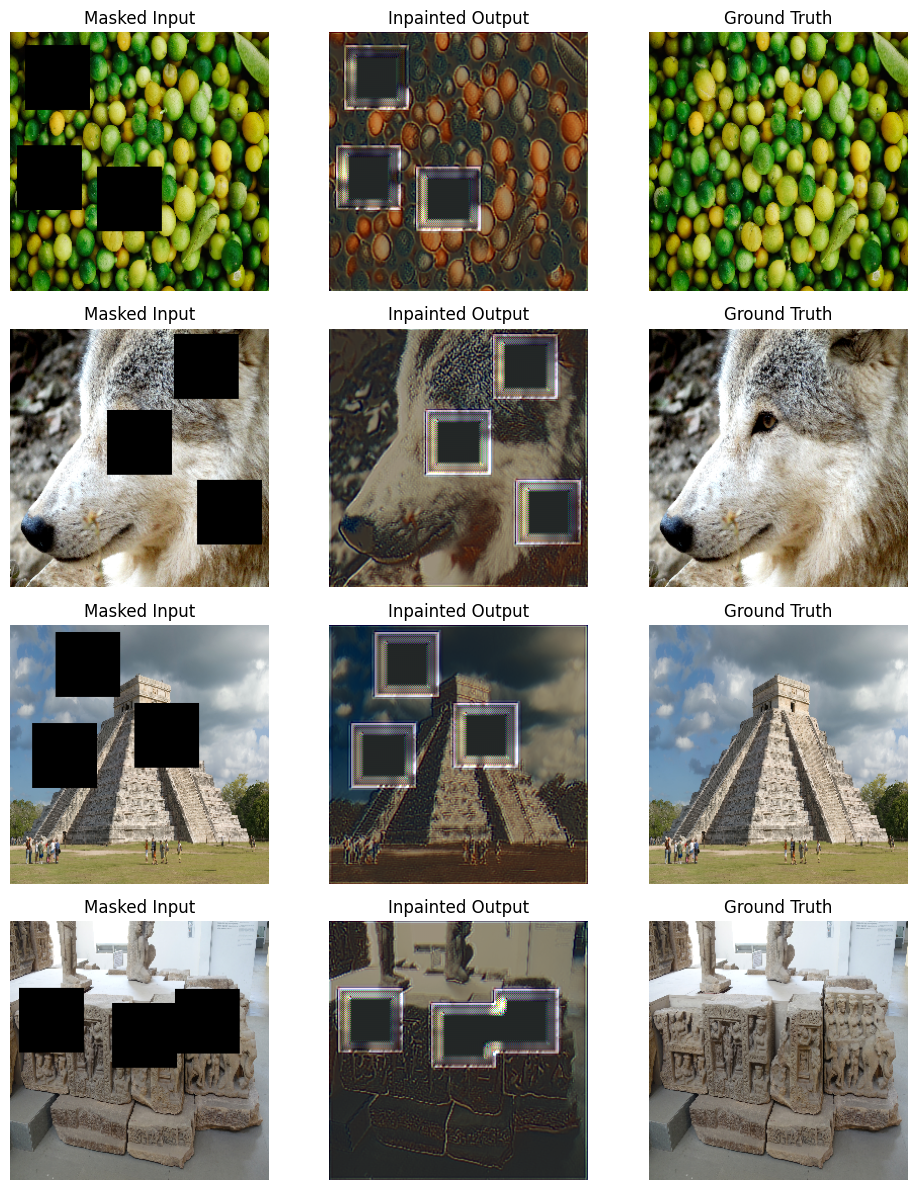

In [27]:
visualize_inpainting(model, eval_dataloader, device)